### **Project work for the course Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**

#### Stefano Poggi Cavalletti - 0000982439

The aim of this project is to perform anomaly detection in time series, in particular on health data related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use an available dataset which contains ECG data of real patients: ECG5000.
After analyzing the data we will use different deep learning techniques like autoencoders and their variations, in order to be able to distinguish a normal signal from an anomaly, meaning that some kind of arrhythmia is present.

The [ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series with 140 timesteps (T = 140). Each sequence corresponds to a single heartbeat from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. The frequency is 60-100 per minute and the duration is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)





In [120]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [121]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'

train_data = pd.read_csv(ecg_train_file)
test_data = pd.read_csv(ecg_test_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

We combine the training and test data into a single dataframe and we drop irrelevant columns.

In [122]:
df = df_train.append(df_test)

In [123]:
df = df.drop(labels='id', axis=1)

In [124]:
# 140 timesteps + target
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [125]:
df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t132,t133,t134,t135,t136,t137,t138,t139,t140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,4
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,2
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,2
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,2


There is a total of 5000 examples, where each row represents a single heartbeat record. We will now name the different classes to perform some data analysis.

In [126]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

### Exploratory Data Analysis

In [127]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

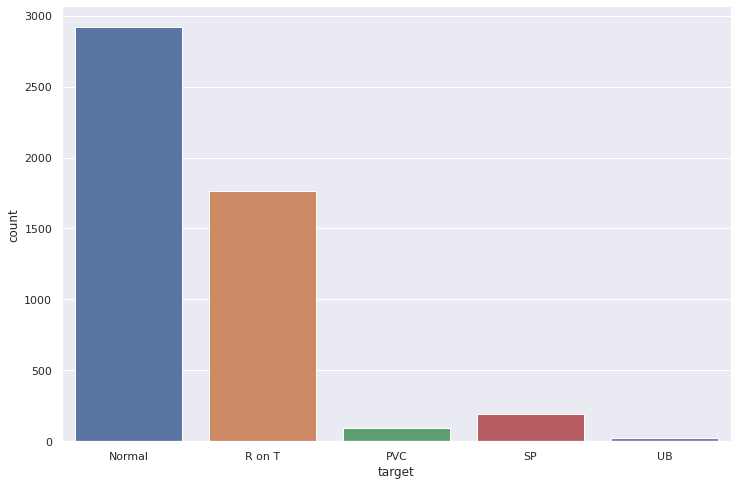

In [128]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

As we can see, classes are very unbalanced, with normal class being the most common with 2919 samples. However, this might turn out useful to train our model. Moreover, if we sum all the remaining anormal samples we get a value of 2081.

Now we plot an averaged time series for each class, smoothed out with one standard deviation on top and bottom of it:

In [129]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

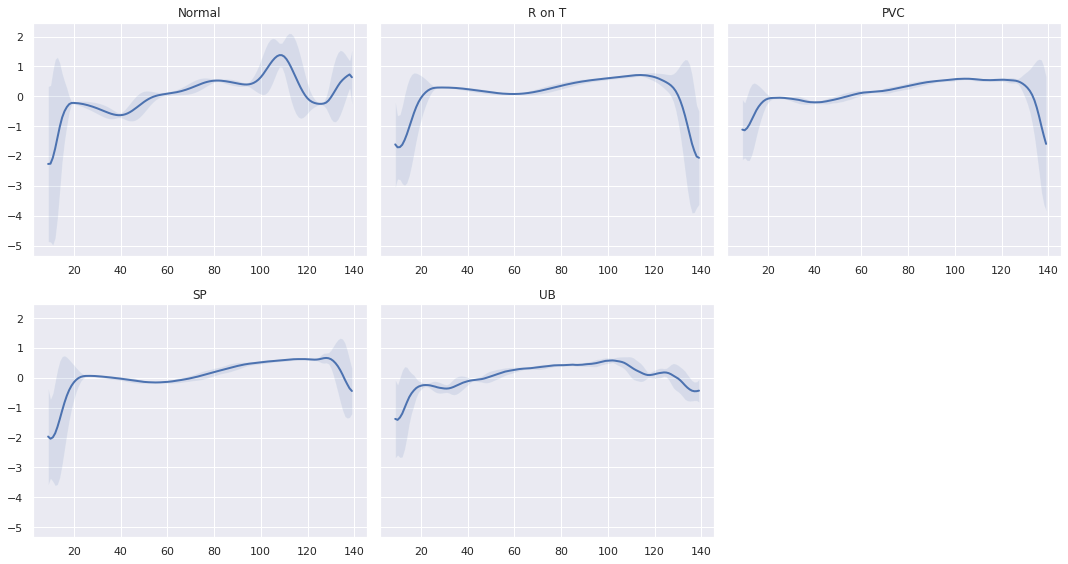

In [130]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(15, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

The normal class has a distinctly different pattern compared to all the other classes.

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

We now split the data into training, validation and test set.

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,-1], 
                                                    test_size=0.33,
                                                    random_state=RANDOM_SEED)

X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                    y_test, 
                                                    test_size=0.5,
                                                    random_state=RANDOM_SEED)

In [132]:
X_train.shape

(3350, 141)

In [133]:
X_val.shape

(825, 141)

In [134]:
X_test.shape

(825, 141)

In [135]:
X_train

array([[-0.42647873, -2.9647912 , -4.1577846 , ...,  1.7172957 ,
        -0.519775  ,  1.        ],
       [-0.98285723, -2.8446093 , -3.7425212 , ...,  1.1985336 ,
        -0.2422427 ,  1.        ],
       [ 0.045005  , -1.1329274 , -1.5485528 , ..., -0.52314885,
         1.1963458 ,  2.        ],
       ...,
       [-1.0320965 , -2.8119009 , -3.5887058 , ...,  1.7765205 ,
         0.75066935,  1.        ],
       [-1.5925409 , -2.4613697 , -2.5241322 , ..., -0.70754117,
         0.35401601,  2.        ],
       [-1.9455858 , -3.8405188 , -3.9946828 , ...,  0.88314532,
        -1.3660438 ,  1.        ]])

In [136]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(X_train[:,:-1])    

In [137]:
X_train[:,:-1] = data_scaled.transform(X_train[:,:-1])
X_val[:,:-1] = data_scaled.transform(X_test[:,:-1])
X_test[:,:-1] = data_scaled.transform(X_test[:,:-1])

In [138]:
X_train

array([[0.46681314, 0.30598663, 0.12742944, ..., 0.78191394, 0.41294765,
        1.        ],
       [0.41180487, 0.31892916, 0.18172118, ..., 0.72852918, 0.43351424,
        1.        ],
       [0.513428  , 0.50326213, 0.46856169, ..., 0.55135431, 0.54012112,
        2.        ],
       ...,
       [0.40693666, 0.32245156, 0.20183108, ..., 0.78800865, 0.50709418,
        1.        ],
       [0.35152641, 0.36020066, 0.34101396, ..., 0.53237887, 0.47770011,
        2.        ],
       [0.31662141, 0.21167853, 0.14875345, ..., 0.69607321, 0.35023474,
        1.        ]])

Anomaly Detection in ECG Data
We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data:

In [139]:
df_train = pd.DataFrame(X_train)
df_val = pd.DataFrame(X_val)
df_test = pd.DataFrame(X_test)

In [140]:
normal_X_train = df_train[df_train.iloc[:,-1] == 1].drop(columns=df_train.columns[-1], axis=1).values
normal_X_train.shape

(1932, 140)

In [141]:
normal_X_val = df_val[df_val.iloc[:,-1] == 1].drop(columns=df_val.columns[-1], axis=1).values
normal_X_val.shape

(492, 140)

In [142]:
normal_X_test = df_test[df_test.iloc[:,-1] == 1].drop(columns=df_test.columns[-1], axis=1).values
normal_X_test.shape

(495, 140)

We'll merge all other classes and mark them as anomalies:

In [143]:
anomaly_X_train = df_train[df_train.iloc[:,-1] > 1].drop(columns=df_train.columns[-1], axis=1).values
anomaly_X_train.shape

(1418, 140)

In [144]:
anomaly_X_val = df_val[df_val.iloc[:,-1] > 1].drop(columns=df_val.columns[-1], axis=1).values
anomaly_X_val.shape

(333, 140)

In [145]:
anomaly_X_test = df_test[df_test.iloc[:,-1] > 1].drop(columns=df_test.columns[-1], axis=1).values
anomaly_X_test.shape

(330, 140)

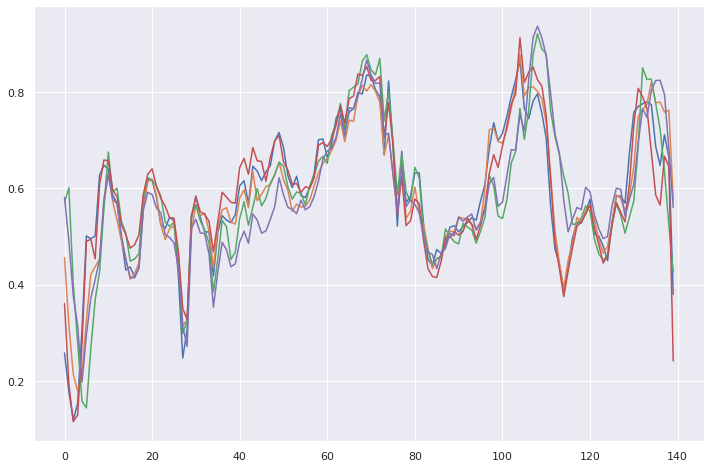

In [146]:
plt.figure(figsize=(12,8)) 

for i in range(5,10):
  plt.plot(normal_X_train[i])

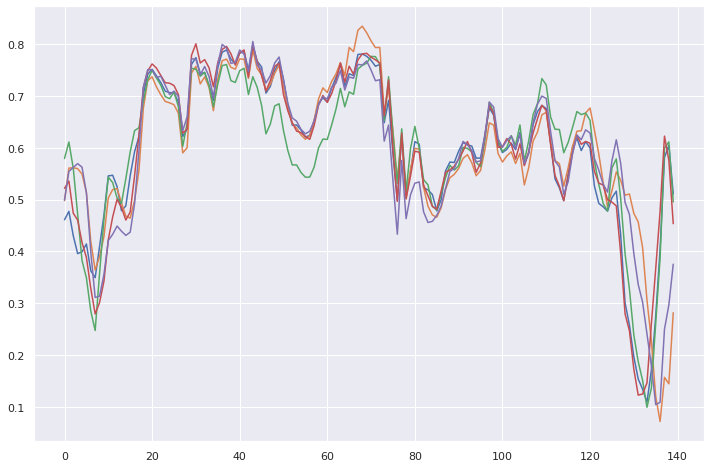

In [147]:
plt.figure(figsize=(12,8)) 
for i in range(5,10):
  plt.plot(anomaly_X_train[i])

## Autoencoder

The objective of an autoencoder is to minimize the reconstruction error of a given input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data. In a sense, Autoencoders try to learn only the most important features (compressed version) of the data.

We will therefore train an autoencoder solely on the normal ECG sequences, such that it reconstructs these examples with minimal error. The idea now is the following: abnormal rhythms should have a higher reconstruction error as the normal sequences, allowing us to classify a rhythm as an anomaly if the reconstruction error is higher than a fixed threshold.

As previously said, the objective is to reconstruct the input as best as possible and this is done by minimizing a loss function, known as reconstruction loss. In this case we will minimize L1Loss, which measures the MAE (Mean Absolute Error). 


In [148]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    # Define the encoder network
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    # Define the decoder network
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    # Define how an evaluation of the network is performed
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [149]:
autoencoder = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=3,
                    mode='min',)

autoencoder.compile(optimizer='adam', loss='mae')

In [150]:
history = autoencoder.fit(normal_X_train, normal_X_train, 
                    epochs=100,
                    batch_size=256,
                    validation_data=(normal_X_val, normal_X_val),
                    callbacks=[early_stopping],
                    shuffle=True)

Epoch 1/100
8/8 [==============================] - 1s 33ms/step - loss: 0.1326 - val_loss: 0.1338
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1239 - val_loss: 0.1188
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1043 - val_loss: 0.1024
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0847 - val_loss: 0.0890
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0684 - val_loss: 0.0830
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0578 - val_loss: 0.0795
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0525 - val_loss: 0.0774
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0497 - val_loss: 0.0767
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0484 - val_loss: 0.0764
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0480 - val_loss: 0.0757
Epoch 11/100
8/8 [========

In [151]:
autoencoder.summary()

Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 8)                 11768     
                                                                 
 sequential_3 (Sequential)   (None, 140)               11900     
                                                                 
Total params: 23,668
Trainable params: 23,668
Non-trainable params: 0
_________________________________________________________________


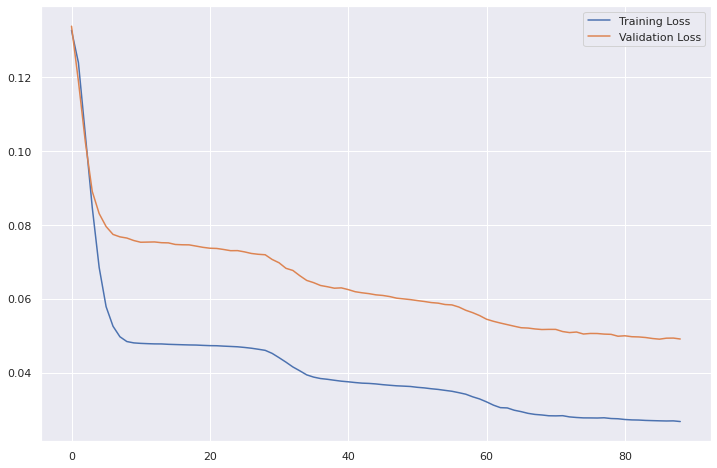

In [152]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

The autoencoder is made of dense layers and is trying to learn the distribution of the signal, in order to reproduce it as output. Since we are training it on the normal data it will learn to reproduce the normal data.

We now pass the normal test data into the model and plot its distribution, comparing it with its original shape.

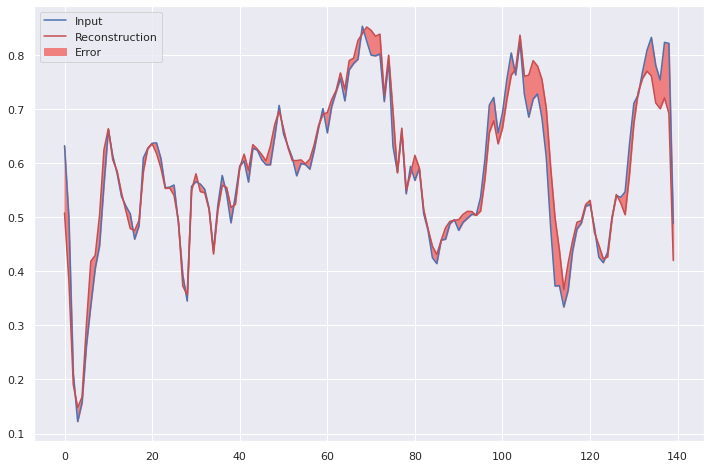

In [153]:
encoded_data = autoencoder.encoder(normal_X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

The same process is done for the anomaly signals

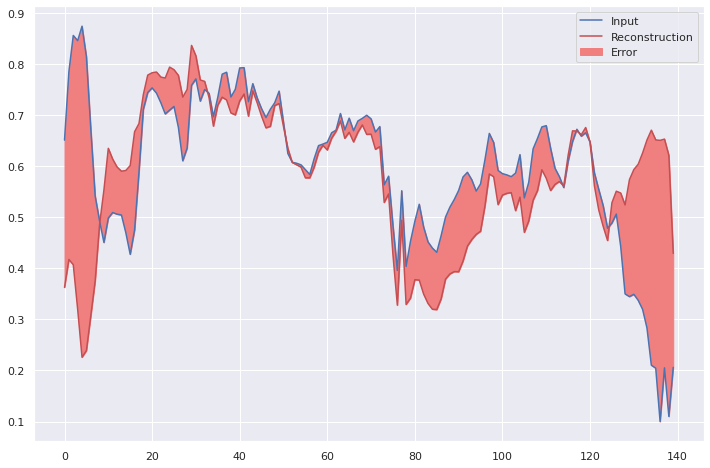

In [154]:
encoded_data = autoencoder.encoder(anomaly_X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Choosing a threshold

As we can see, normal data is fit accurately, while the anomalous data does has a higher amount of error.

We can now compute the mean absolute error (MAE) of the normal and abnormal data, plot their distribution and based on that we choose the threshold.

In [155]:
reconstruction = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mae(reconstruction, normal_X_train) 

61/61 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

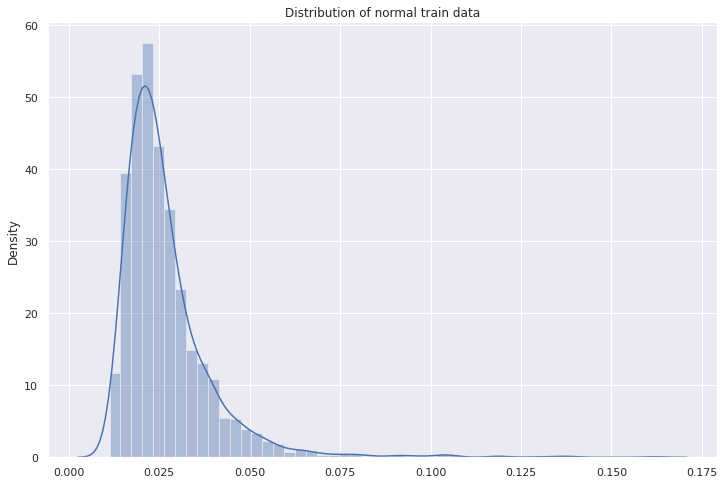

In [156]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In [157]:
mean_normal = np.mean(train_loss)
std_normal = np.std(train_loss)

In [158]:
threshold = mean_normal + std_normal
print("Threshold: ", threshold)

Threshold:  0.040090346416986625


## Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:
- If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal test data

We now calculate the loss on the test data, plot the histogram and compute the correct number of predictions given the threshold.

In [159]:
reconstruction_test = autoencoder.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mae(reconstruction_test, normal_X_test) 

16/16 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

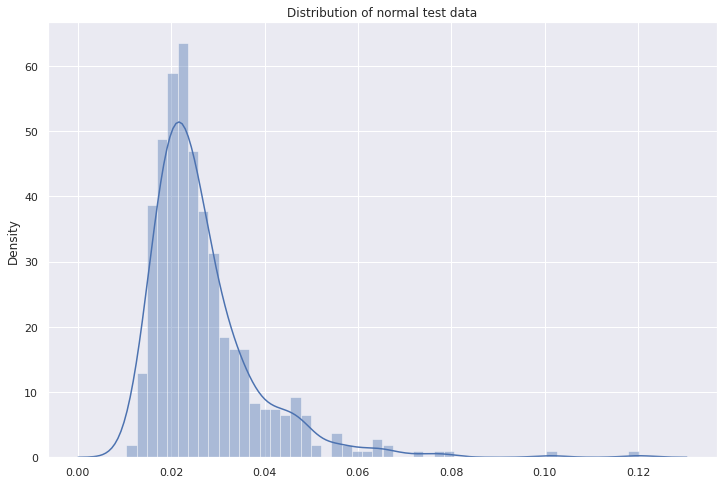

In [160]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

In [161]:
correct = [l <= threshold for l in test_loss_normal.numpy()]
print(f'Correct normal predictions: {np.count_nonzero(correct)}/{len(normal_X_test)}')

Correct normal predictions: 437/495


### Anomalous test data

The same process is applied to anomalous test data

In [162]:
reconstruction_anomalies = autoencoder.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mae(reconstruction_anomalies, anomaly_X_test)

11/11 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

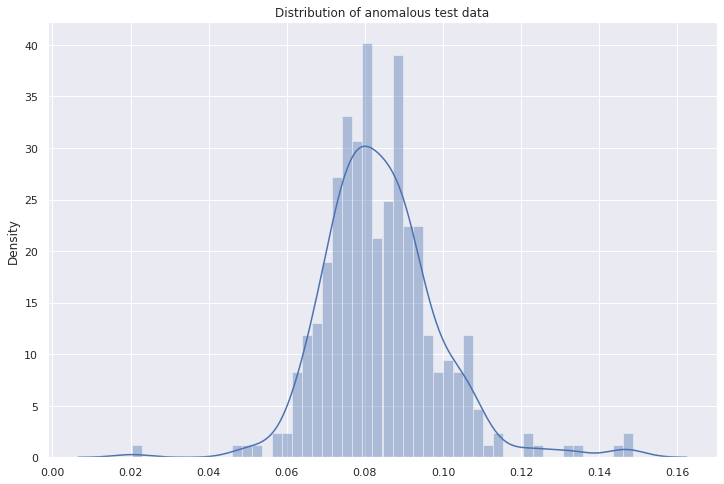

In [163]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

In [164]:
correct = [l > threshold for l in test_loss_anomalies.numpy()]
print(f'Correct anomaly predictions: {np.count_nonzero(correct)}/{len(anomaly_X_test)}')

Correct anomaly predictions: 329/330


As we can see, it seems that the threshold allows to distinguish well the anomalies from normal signals. We now put everything together.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


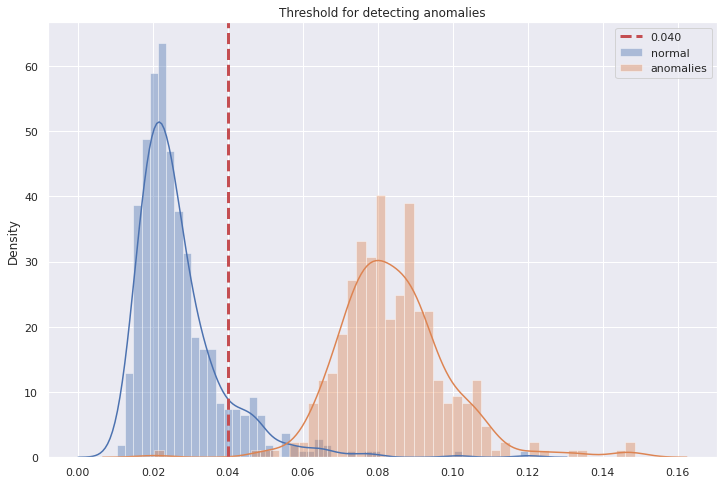

In [165]:
sns.set(rc={'figure.figsize':(12,8)})

# plot two histograms of normal and abnormal data
sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomalies')

# plot a vertical line representing the threshold
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

# add legend and title
plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

## Confusion matrix and ROC curve

In order to plot the confusion matrix and ROC curve we first need to count 
the amount of false positives or false negatives: we compare the threshold with the test losses of normal and abnormal data and get an array of boolean values.

In [166]:
# We correctly detect normal data if the normal loss is smaller than the threshold
pred_normal = tf.math.less(test_loss_normal, threshold)
# We correctly detect abnormal data if the normal loss is greater than the threshold
pred_anomaly = tf.math.greater(test_loss_anomalies, threshold)

In [167]:
pred_normal_true = tf.math.count_nonzero(pred_normal).numpy()
pred_normal_false = normal_X_test.shape[0] - pred_normal_true
pred_normal_true, pred_normal_false

(437, 58)

In [168]:
pred_anomaly_true = tf.math.count_nonzero(pred_anomaly).numpy()
pred_anomaly_false = anomaly_X_test.shape[0] - pred_anomaly_true
pred_anomaly_true, pred_anomaly_false

(329, 1)

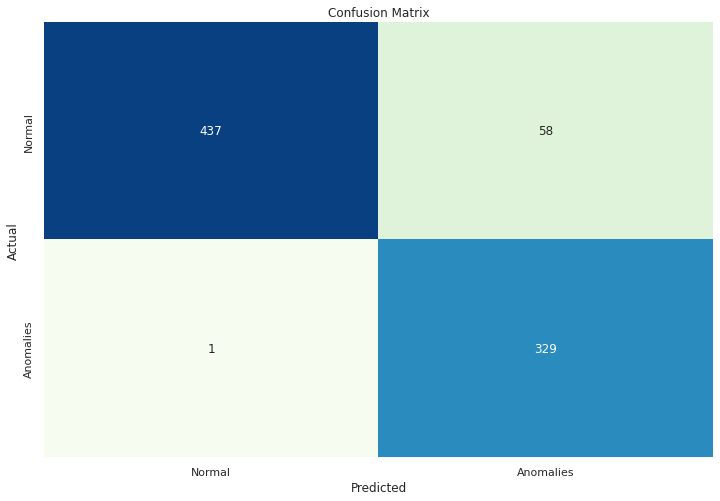

In [169]:
cm = [[pred_normal_true, pred_normal_false], 
      [pred_anomaly_false, pred_anomaly_true]]

# cm = [[pred_anomaly_true, pred_anomaly_false]
#       [pred_normal_false, pred_normal_true]]

categories = ['Normal', 'Anomalies']

g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories, 
            cbar=False, 
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

Now we combine the first three cells of this block into one as a function which will predict true positives (TP), false negatives (FN), true negatives (TN) and false positives (FP)

In [170]:
def predictor(normal, abnormal, threshold):
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)
    # We correctly detect abnormal data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(abnormal, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = abnormal.shape[0] - tp
    
    return tp,tn,fp,fn

In [171]:
tpr_values = []
fpr_values = []

for thresh in np.linspace(0, 1, 100):
    tp,tn,fp,fn = predictor(test_loss_normal, 
                            test_loss_anomalies, 
                            thresh/10)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_values.append(tpr)
    fpr_values.append(fpr)

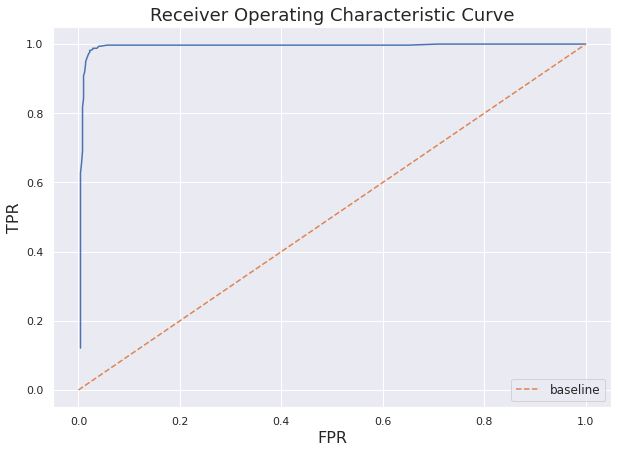

In [172]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

### Variational autoencoder

Autoencoders have a strong tendency to overfit on the training data. In class you got to know variational autoencoders, which are designed to mitigate this problem. First, define a function performing the sampling in the laten space using the reparametrization trick (this allows backpropagation of the gradient).

In [173]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [174]:
def encoder_model(normal_train_data):
    encoder_inputs = tf.keras.Input(shape=(normal_train_data.shape[1]))
    x = layers.Dense(32, activation="relu")(encoder_inputs)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    
    # So far we just copied the network from above
    # Now we generate the latent space of mean and log-variance, in this case of dimension 8
    z_mean = layers.Dense(8, name="z_mean")(x)
    z_log_var = layers.Dense(8, name="z_log_var")(x)
    
    # Sample from these distributions
    z = Sampling()([z_mean, z_log_var])
    
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [175]:
def decoder_model(normal_train_data):
    # Recreate the network we used for the 'normal' autoencoder
    latent_inputs = tf.keras.Input(shape=(8,))
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(32, activation="relu")(x)
    decoder_outputs = layers.Dense(normal_train_data.shape[1], activation="relu")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

In [176]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [178]:
# Get the encoder and decoder models
encoder = encoder_model(normal_X_train)
decoder = decoder_model(normal_X_train)

# Get the combined model
vae = VAE(encoder, decoder)

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Fit the model to the training set
history = vae.fit(normal_X_val, normal_X_val, 
          epochs=80, 
          batch_size=128,
          shuffle=True)

Epoch 1/80
4/4 [==============================] - 1s 8ms/step - loss: 5.0493 - reconstruction_loss: 5.0277 - kl_loss: 0.0216
Epoch 2/80
4/4 [==============================] - 0s 5ms/step - loss: 4.6271 - reconstruction_loss: 4.5941 - kl_loss: 0.0330
Epoch 3/80
4/4 [==============================] - 0s 5ms/step - loss: 4.2415 - reconstruction_loss: 4.2163 - kl_loss: 0.0252
Epoch 4/80
4/4 [==============================] - 0s 4ms/step - loss: 3.8773 - reconstruction_loss: 3.8603 - kl_loss: 0.0169
Epoch 5/80
4/4 [==============================] - 0s 5ms/step - loss: 3.5927 - reconstruction_loss: 3.5788 - kl_loss: 0.0139
Epoch 6/80
4/4 [==============================] - 0s 5ms/step - loss: 3.3449 - reconstruction_loss: 3.3176 - kl_loss: 0.0273
Epoch 7/80
4/4 [==============================] - 0s 4ms/step - loss: 3.0768 - reconstruction_loss: 3.0458 - kl_loss: 0.0310
Epoch 8/80
4/4 [==============================] - 0s 5ms/step - loss: 2.8482 - reconstruction_loss: 2.8144 - kl_loss: 0.0339


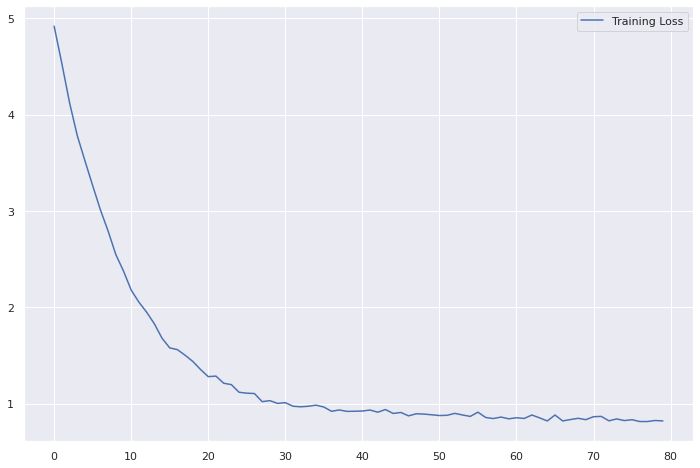

In [179]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

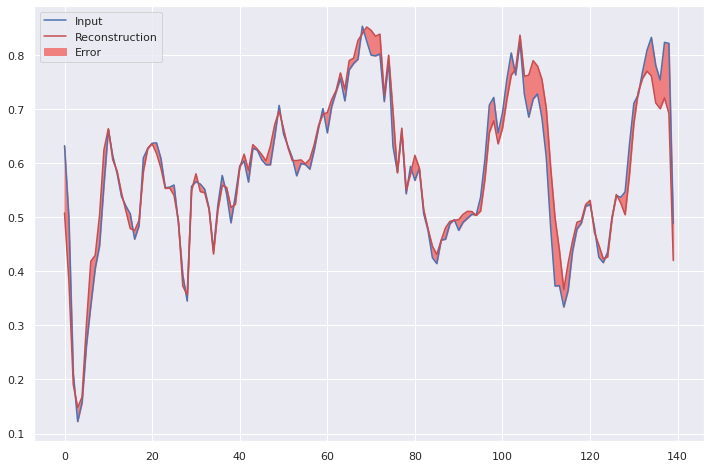

In [180]:
encoded_data_vae = autoencoder.encoder(normal_X_test).numpy()
decoded_data_vae = autoencoder.decoder(encoded_data_vae).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_data_vae[0], 'r')
plt.fill_between(np.arange(140), decoded_data_vae[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

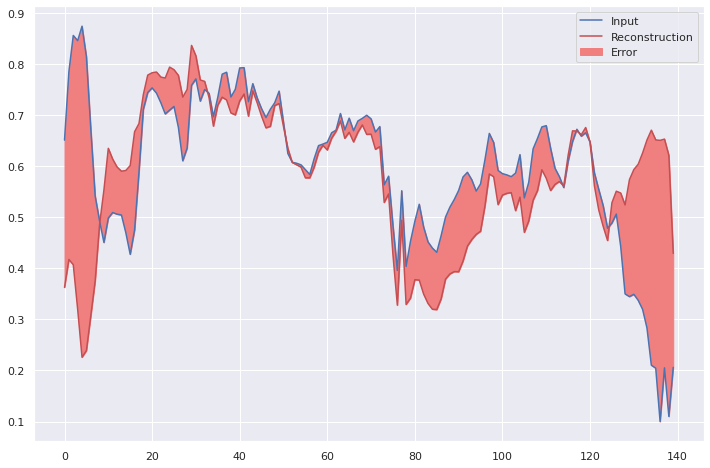

In [181]:
encoded_data_vae = autoencoder.encoder(anomaly_X_test).numpy()
decoded_data_vae = autoencoder.decoder(encoded_data_vae).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_data_vae[0], 'r')
plt.fill_between(np.arange(140), decoded_data_vae[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### LSTM Autoencoder

In [ ]:
train_data = np.expand_dims(normal_X_train,2)

In [ ]:
train_data.shape

In [ ]:
# lstm autoencoder recreate sequence
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

'''class LSTMAutoEncoder(Model):
    def __init__(self):
      super(LSTMAutoEncoder, self).__init__()'''


# define model
LSTMAutoEncoder = tf.keras.Sequential()
LSTMAutoEncoder.add(LSTM(32, activation='relu', input_shape=(140,1), return_sequences=True))
LSTMAutoEncoder.add(LSTM(16, activation='relu', return_sequences=False))
LSTMAutoEncoder.add(RepeatVector(140))
LSTMAutoEncoder.add(LSTM(16, activation='relu', return_sequences=True))
LSTMAutoEncoder.add(LSTM(32, activation='relu', return_sequences=True))
LSTMAutoEncoder.add(TimeDistributed(Dense(normal_X_train.shape[1])))
LSTMAutoEncoder.summary()

In [ ]:
plot_model(LSTMAutoEncoder, show_shapes=True)

In [ ]:
LSTMAutoEncoder.compile(optimizer='adam', loss='mae')

# fit model
LSTMAutoEncoder.fit(train_data, train_data, epochs=20, batch_size=128, shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()